# Цель Блокнота

Рассмотрение механизмов интерпритации моделей машинного обучения в рамках библиотеки `shap`


# Import библиотек

Обновим `scikit-learn` чтобы воспользоваться некими новинками

Например `TargetEncoder`

In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00


In [ ]:
# @title Гигантский блок импорта  { display-mode: "form" }

import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

from sklearn.linear_model import SGDRegressor # Линейная регрессия с градиентным спуском от scikit-learn

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import TargetEncoder

from catboost import Pool
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')

# Набор данных


Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

# Загрузка данных

Загружаем наши данные из файла по прямой ссылке на git-hub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/Basic_ML_Alg/main/cars_moldova_clean.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


In [ ]:
# Добавим пару рандомных признаков для последующего анализа
DF['random_feature_1'] = np.random.random(size = DF.shape[0]) # равномерное распределение
DF['random_feature_2'] = np.random.normal(size = DF.shape[0]) # нормальное распределение

Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

Предварительная обработка из [предыдущего блокнота](https://colab.research.google.com/drive/1es_OrShFiuaeOnlPjX2B1geHDM-XfofM?usp=sharing)

Из предварительной обработки исключена колонка `Price(euro)`, поскольку она является целевой меткой и будет обработана отдельно


In [ ]:
# @title Всякие там Pipeline { display-mode: "form" }


num_pipe_distance = Pipeline([
    ('scaler', StandardScaler())
])

num_distance = ['Distance']

num_pipe_engine = Pipeline([
    ('scaler', StandardScaler())
])

num_engine = ['Engine_capacity(cm3)']

num_pipe_year = Pipeline([
    ('power', PowerTransformer())
])

num_year = ['Year']

cat_pipe_transmission = Pipeline([
    ('encoder', OrdinalEncoder())

])

cat_transmission = ['Transmission']

cat_pipe_style_fuel = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])

cat_style_fuel = ['Style', 'Fuel_type']

cat_pipe_make_model = Pipeline([
    ('encoder', TargetEncoder(target_type="continuous")),
        ('scaler', StandardScaler())
])

cat_make_model = ['Make', 'Model']

random = ['random_feature_1', 'random_feature_2']



# Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('random', "passthrough", random),
])

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('cat_transmission', cat_pipe_transmission, cat_transmission),
    ('cat_style_fuel', cat_pipe_style_fuel, cat_style_fuel),
    ('cat_make_model', cat_pipe_make_model, cat_make_model),
        ('random', "passthrough", random),
])

# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns_num = np.hstack([num_distance,
                    num_engine,
                    num_year, random])

In [ ]:
# @title Вспомагательные функции { display-mode: "form" }

def get_coefs (model):
    """Берем веса как атрибуты обученной модели.
    Входные переменные:
    ===========
    model: обученная модель
    """
    B0=model.intercept_[0]
    B=model.coef_
    return B0, B

def print_model (B0,B,features_names):
    """Написание уравнения модели.
    Входные переменные:
    ===========
    B0: смещение (независимый коэффициент)
    weights: веса признаков
    features_names: список названий признаков
    """
    line='{:.3f}'.format(B0)
    sign=['+','-']
    for p,(fn,b) in enumerate(zip(features_names,B)):
        line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

    print('Решение')
    print(line)

def vis_weigths(weights,features_names = None, width = 1200, height = 600):
    """Отрисовка весов.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    """
    numbers = np.arange(0,len(weights))                 # создаем массив от 0 до количество весов-1
    if features_names:
        tick_labels = np.hstack(['B0',features_names])
    else:
        tick_labels = ['B'+str(num) for num in numbers] # создаем "названия" весов

    ind = np.argsort(np.abs(weights))
    weights = weights[ind][::-1]

    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=width,
                height=height,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels[ind][::-1],
                                         )
                )

    fig.show()

def vis_weigths_threshold(weights, feature_names, threshold, width = 1200, height = 600):
    """Отрисовка весов с фильтром.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    threshold: порог "значимости" коэффициентов
    """
    # фильтруем веса коэффициентов
    mask = np.abs(weights) >= threshold
    weights_filtered = weights[mask]
    feature_names_filtered = [name for name, m in zip(feature_names, mask[1:]) if m]

    # Рисуем столбчатую диаграмму
    vis_weigths(weights_filtered,feature_names_filtered, width = width, height = height)

def calculate_metric(model_pipe, X, y, metric = r2_score, **kwargs):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model, **kwargs)


def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])


def analyse_linear_model(model, X_train, y_train, X_val, y_val, metrics, metric_names, scoring_reg, cv_rule):
    B0, B = get_coefs(model)
    features_names = list(columns_num)
    print_model(B0,B,features_names)

    Bs = np.hstack([B0,B])
    vis_weigths(Bs,features_names)

    analyse_model(model, X_train, y_train, X_val, y_val, metrics, metric_names, scoring_reg, cv_rule)


def analyse_model(model, X_train, y_train, X_val, y_val, metrics, metric_names, scoring_reg, cv_rule):

    for name, metric,  in zip(metric_names, metrics):
        print(name+ f" на тренировочной выборке: {calculate_metric(model, X_train, y_train, metric):.4f}")
        print(name+ f" на валидационной выборке: {calculate_metric(model, X_val, y_val, metric):.4f}")

    cross_validation (X_train, y_train,
                    model,
                    scoring_reg,
                    cv_rule)

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

cv_rule = ShuffleSplit(n_splits=5, random_state = 42)

metrics = [mse, r2_score]

metric_names = ['mse', 'r2_score']

# Линейная Регрессия

**Считываем данные, разбиваем на тестовую и тренировочную**

In [ ]:
# не забываем удалить целевую переменную цену из признаков
X,y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']

# разбиваем на тестовую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

Запускаем Pipeline из предварительной обработки и модели

In [ ]:
pipe_all_transform = Pipeline([
    ('preprocessors', preprocessors_all),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())
    )
])

In [ ]:
%%time
pipe_all_transform.fit(X_train, y_train)

CPU times: user 289 ms, sys: 7.1 ms, total: 296 ms
Wall time: 317 ms


Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('cat_transmission',
                                                  Pipeline(steps=[('encoder',
                                                                   Ordinal...
                                                                                 sparse_output=False))]),
                                                  ['Style', 'Fuel_type']),
                                                 ('cat_make_model',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder(target_type='continuous')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Make', 'Model']),
                                                 ('random', 'passthrough',
                                                  ['random_feature_1',
                                                   'random_feature_2'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

# CatBoost

In [ ]:
train_data = Pool(
    data=X_train,
    label=y_train,
    cat_features = cat_columns,
    feature_names=list(X_train.columns)
)

eval_data = Pool(
    data=X_val,
    label=y_val,
    cat_features = cat_columns,
    feature_names=list(X_train.columns)
)

In [ ]:
model_reg = CatBoostRegressor(iterations = 1000,
                           early_stopping_rounds=100,
                           verbose = 100,
                           cat_features = cat_columns,
                           depth = 3,
                           eval_metric= 'MAE'
                           )


In [ ]:
%%time
model_reg.fit(X=train_data,
          eval_set=eval_data,
          );

Learning rate set to 0.083159
0:	learn: 5341.6428495	test: 5427.6644559	best: 5427.6644559 (0)	total: 62.3ms	remaining: 1m 2s
100:	learn: 2049.4252973	test: 2073.1290595	best: 2073.1290595 (100)	total: 1.32s	remaining: 11.8s
200:	learn: 1920.8412764	test: 1951.0207406	best: 1951.0207406 (200)	total: 2.33s	remaining: 9.24s
300:	learn: 1872.1155989	test: 1908.8649247	best: 1908.8649247 (300)	total: 4.83s	remaining: 11.2s
400:	learn: 1836.9407192	test: 1881.1963428	best: 1881.1963428 (400)	total: 7.63s	remaining: 11.4s
500:	learn: 1811.9401010	test: 1862.8773916	best: 1862.8773916 (500)	total: 10s	remaining: 10s
600:	learn: 1791.7423010	test: 1848.1413760	best: 1848.1413760 (600)	total: 12.8s	remaining: 8.49s
700:	learn: 1772.8925358	test: 1834.7397330	best: 1834.6311009 (698)	total: 15.2s	remaining: 6.47s
800:	learn: 1756.3604616	test: 1821.8104050	best: 1821.8104050 (800)	total: 17.7s	remaining: 4.39s
900:	learn: 1742.2511353	test: 1814.2867602	best: 1814.2198253 (899)	total: 21.1s	rema

# Shap

Надо устанавливать библиотеку Shap - но тут стандартно

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.7 MB/s eta 0:00:00


In [ ]:
import shap
shap.initjs()

# Для линейной модели

### Первая боль

С `pipeline` пока полноценную интеграцию не завезли

Поэтому трансформируем исходные данные, обратившись к части обученного `pipeline`

In [ ]:
data_transform = pipe_all_transform['preprocessors'].transform(X_val)

## Интерфейс работы в shap

Создаем объект класса

И затем его применяем к данным

Наиболее общий - `Explainer`

In [ ]:
%time
# нужно задать метод predict от объекта класса модели машинного обучения. любой
explainer_line = shap.Explainer(pipe_all_transform['model'].regressor_.predict, # модель (не pipeline)
                           data_transform, # данные (которые подставляются в итоговую модель)
                           feature_names=pipe_all_transform['preprocessors'].get_feature_names_out()
                           # название признаков. чтобы не скучно "feature 1"
                           )
#
shap_values_line = explainer_line(data_transform)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


PermutationExplainer explainer: 9747it [03:32, 45.48it/s]                          


Полученный объект - своеобразный словарь где всё

In [ ]:
shap_values_line

.values =
array([[ 4.13378982e-03,  5.49790435e-01,  2.12958861e-01, ...,
         7.84719956e-01,  1.22205876e-04,  1.10885347e-03],
       [ 2.06144187e-03,  5.92581828e-02,  2.12958861e-01, ...,
         1.68217527e-01, -8.19904778e-04, -6.17213041e-03],
       [ 2.36330560e-05, -9.16748180e-02,  1.20087688e-01, ...,
         8.80526156e-02, -1.22990308e-03,  3.34584575e-04],
       ...,
       [ 2.47591146e-03,  8.98221154e-02,  2.93054920e-02, ...,
        -3.94111773e-02,  1.09244579e-03,  3.72806222e-03],
       [-3.94836718e-03,  4.74323935e-01, -3.94846036e-01, ...,
         4.27368463e-01,  1.87175070e-03, -9.78009573e-03],
       [ 2.44137233e-03, -5.39415678e-02,  4.05157151e-01, ...,
         3.54053671e-02, -6.80085128e-04, -3.86234276e-03]])

.base_values =
array([-0.01260428, -0.01260428, -0.01260428, ..., -0.01260428,
       -0.01260428, -0.01260428])

.data =
array([[-1.45274682,  4.68549151,  0.33699568, ...,  3.26935764,
         0.52817407, -0.25348799],
       [-0

## Графиков тут много

### простые столбчатые диаграммы

Для глобальной интерпретируемости

Почти как feature / permutation importance

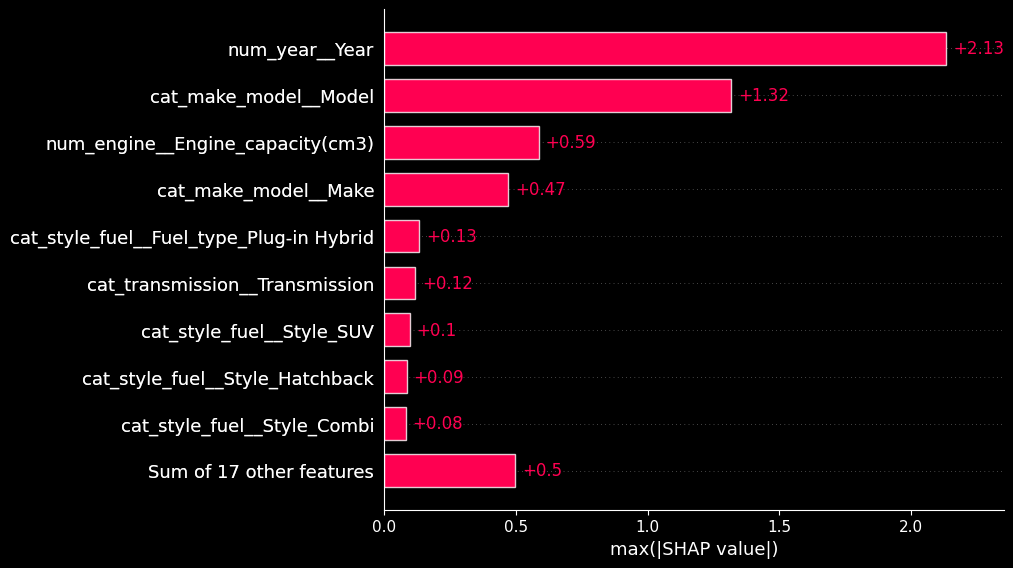

In [ ]:
shap.plots.bar(shap_values_line.abs.max(0))

`Year` и `Model` всё ещё в топе



### Скатерограмма + Что-то от столбчатой диаграммы

График поинтересней

Тут отсортированы по "разросу влияния" (по вертикали)

По горизонтали - как конкретное значение признака влияет на предсказание

Цветом - значение признака (от минимального голубого до максимального красного



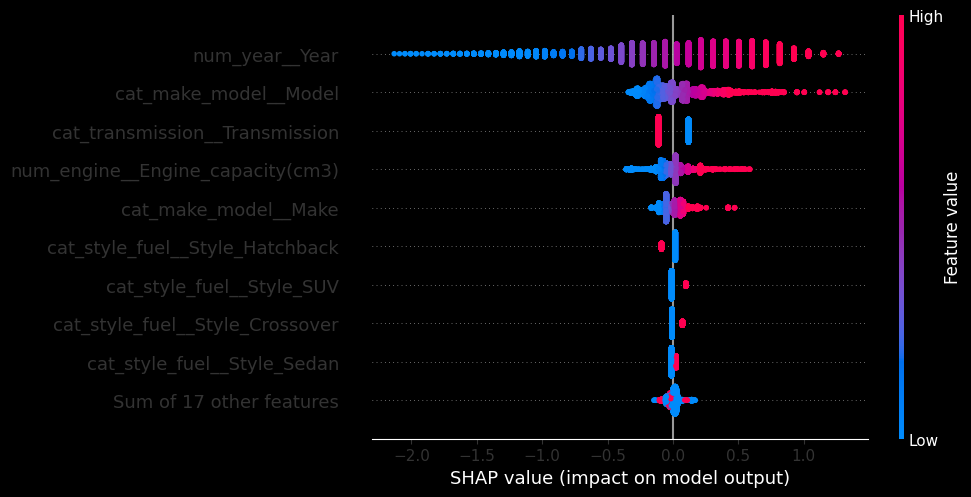

In [ ]:
shap.plots.beeswarm(shap_values_line)

Для индивидуальных объяснений

In [ ]:
#@title { run: "auto" }
index  = 3150 #@param {type:"slider", min:0, max:9746, step:10}

shap.initjs() # надо добавлять для графиков где необходим JS
shap.plots.force(shap_values_line[index])

Еще один индивидуальный график

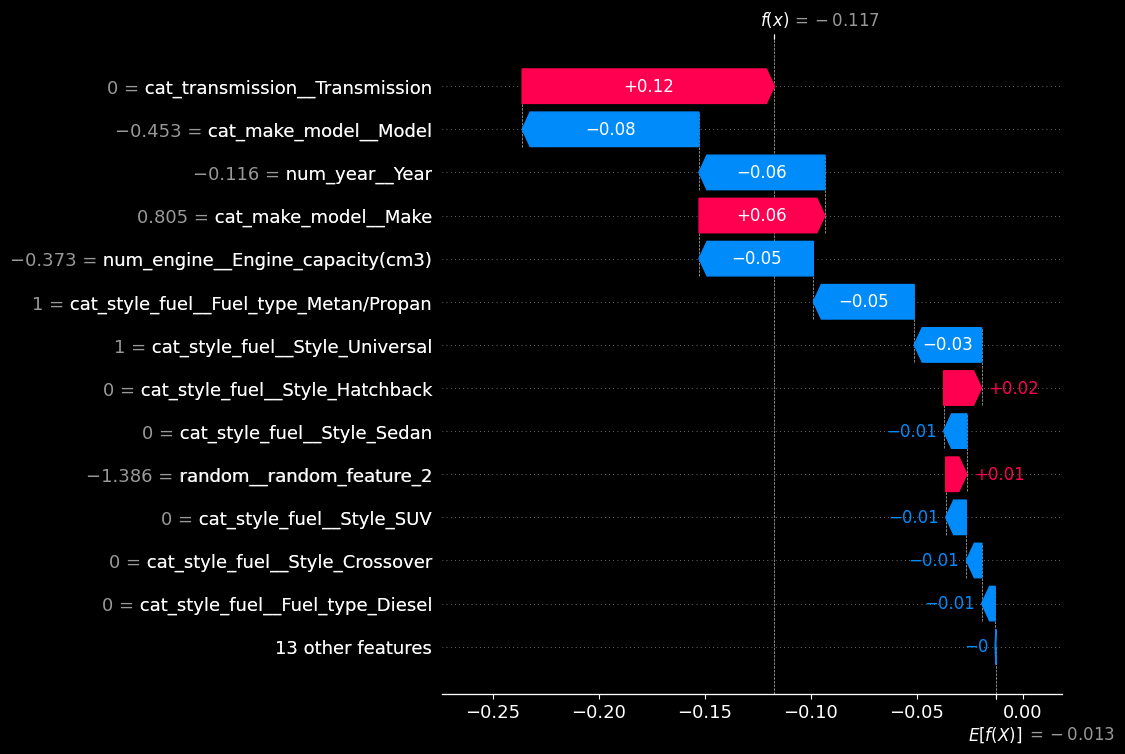

In [ ]:
#@title { run: "auto" }
index  = 5300 #@param {type:"slider", min:0, max:9746, step:10}

shap.plots.waterfall(shap_values_line[index],
                     max_display=14)

Несколько индивидуальных предсказаний

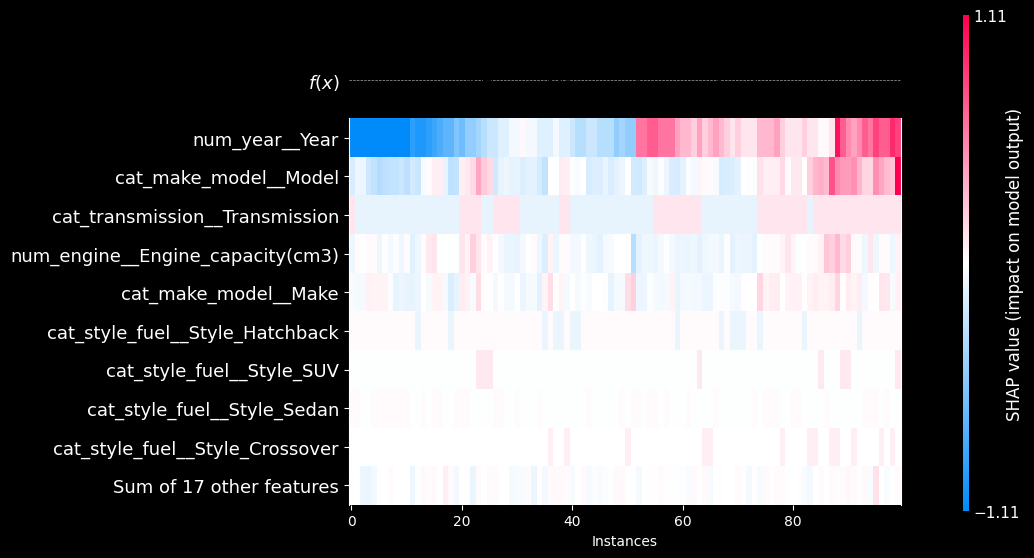

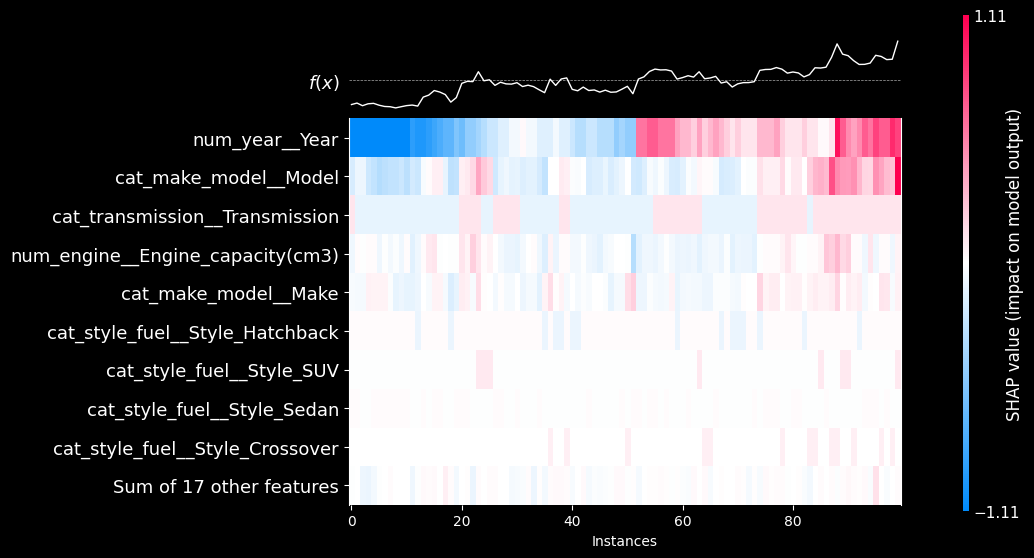

In [ ]:
#@title { run: "auto" }
index  = 2900 #@param {type:"slider", min:0, max:9646, step:10}

f1 = plt.figure()

shap.plots.heatmap(shap_values_line[index:index+100],
                       );

# за темный фон, как за любые принципы нужно страдать
f1.gca().get_lines()[1].set_color('white')

f1

Индивидуальные (в плане признаков) графики

Скатерограмнки, но можно подкрафиать по другим признакам (проверка со-зависимости)

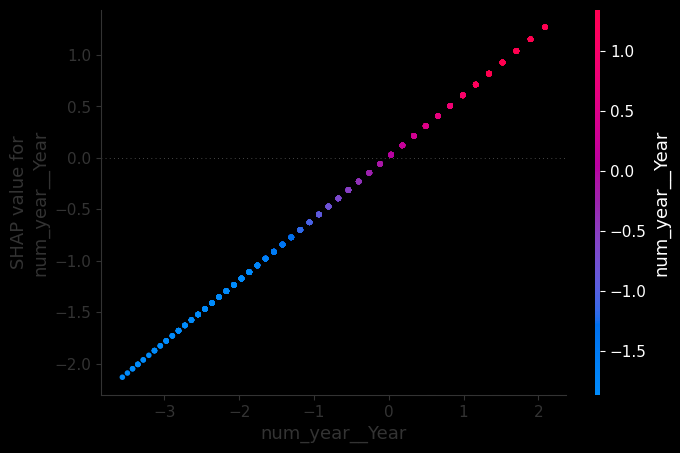

In [ ]:
#@title { run: "auto" }
index_plot  = "num_year__Year" #@param ['num_distance__Distance', 'num_engine__Engine_capacity(cm3)',  'num_year__Year', 'cat_transmission__Transmission', 'cat_style_fuel__Style_Cabriolet', 'cat_style_fuel__Style_Combi', 'cat_style_fuel__Style_Coupe', 'cat_style_fuel__Style_Crossover', 'cat_style_fuel__Style_Hatchback', 'cat_style_fuel__Style_Microvan', 'cat_style_fuel__Style_Minivan', 'cat_style_fuel__Style_Pickup','cat_style_fuel__Style_Roadster', 'cat_style_fuel__Style_SUV', 'cat_style_fuel__Style_Sedan', 'cat_style_fuel__Style_Universal', 'cat_style_fuel__Fuel_type_Diesel', 'cat_style_fuel__Fuel_type_Electric', 'cat_style_fuel__Fuel_type_Hybrid', 'cat_style_fuel__Fuel_type_Metan/Propan', 'cat_style_fuel__Fuel_type_Petrol', 'cat_style_fuel__Fuel_type_Plug-in Hybrid', 'cat_make_model__Make', 'cat_make_model__Model', 'random__random_feature_1', 'random__random_feature_2'] {allow-input: true}
index_color  = "num_year__Year" #@param ['num_distance__Distance', 'num_engine__Engine_capacity(cm3)',  'num_year__Year', 'cat_transmission__Transmission', 'cat_style_fuel__Style_Cabriolet', 'cat_style_fuel__Style_Combi', 'cat_style_fuel__Style_Coupe', 'cat_style_fuel__Style_Crossover', 'cat_style_fuel__Style_Hatchback', 'cat_style_fuel__Style_Microvan', 'cat_style_fuel__Style_Minivan', 'cat_style_fuel__Style_Pickup','cat_style_fuel__Style_Roadster', 'cat_style_fuel__Style_SUV', 'cat_style_fuel__Style_Sedan', 'cat_style_fuel__Style_Universal', 'cat_style_fuel__Fuel_type_Diesel', 'cat_style_fuel__Fuel_type_Electric', 'cat_style_fuel__Fuel_type_Hybrid', 'cat_style_fuel__Fuel_type_Metan/Propan', 'cat_style_fuel__Fuel_type_Petrol', 'cat_style_fuel__Fuel_type_Plug-in Hybrid', 'cat_make_model__Make', 'cat_make_model__Model', 'random__random_feature_1', 'random__random_feature_2'] {allow-input: true}


shap.plots.scatter(
                   shap_values_line[:,index_plot],
                   color=shap_values_line[:,index_color]
                  )

# Для CatBoost

In [ ]:
%time
explainer_cb = shap.TreeExplainer(model_reg,
                                  feature_names=X_val.columns)

shap_values_cb = explainer_cb(X_val)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


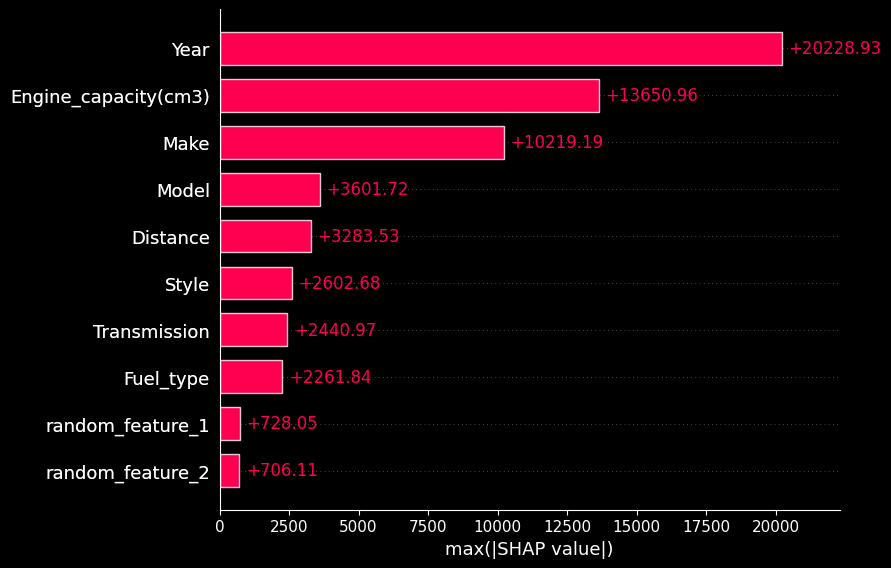

In [ ]:
shap.plots.bar(shap_values_cb.abs.max(0))

График поинтересней

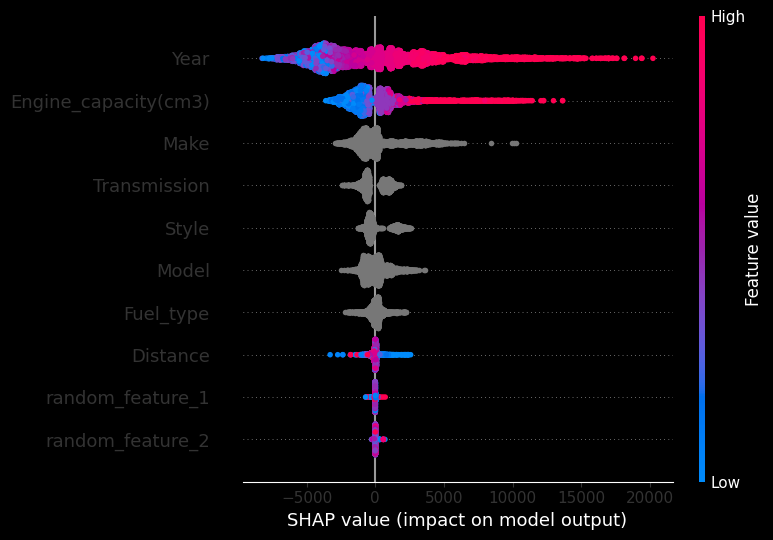

In [ ]:
shap.summary_plot(shap_values_cb, X_val, )

Для индивидуальных объяснений

In [ ]:
shap_values_cb

.values =
array([[ 3.99991874e+03,  1.64885384e+03,  1.33072140e+03, ...,
         5.60148595e+02,  1.41769043e+02, -1.76029506e+01],
       [-2.22101236e+02,  7.25565190e+02, -1.52385541e+02, ...,
         8.41873630e+02,  6.76096369e+00,  1.71062869e+01],
       [ 1.68207730e+03, -1.30576835e+02, -9.87831671e+02, ...,
         6.58296753e+02,  3.69018530e+01, -2.48246218e+01],
       ...,
       [-4.40832909e+02, -2.15435686e+02, -1.94795497e+03, ...,
         6.97670592e+02, -1.49645550e+01,  6.11109638e+00],
       [ 1.25853211e+03,  2.29429183e+02, -6.71468048e+03, ...,
         4.86812717e+02,  2.55334356e+01,  4.30460177e+01],
       [-9.66116517e+02,  2.28785932e+02,  1.39488221e+03, ...,
         7.98354952e+02,  3.61859584e+00, -7.02791742e+01]])

.base_values =
array([8928.53801994, 8928.53801994, 8928.53801994, ..., 8928.53801994,
       8928.53801994, 8928.53801994])

.data =
array([['Porsche', 'Cayenne', 2011, ..., 'Automatic', 0.5281740694111451,
        -0.2534879896059

In [ ]:
#@title { run: "auto" }
index  = 4030 #@param {type:"slider", min:0, max:9746, step:10}

shap.initjs() # надо добавлять для графиков где необходим JS
shap.plots.force(shap_values_cb[index], X_val)

Еще один индивидуальный график

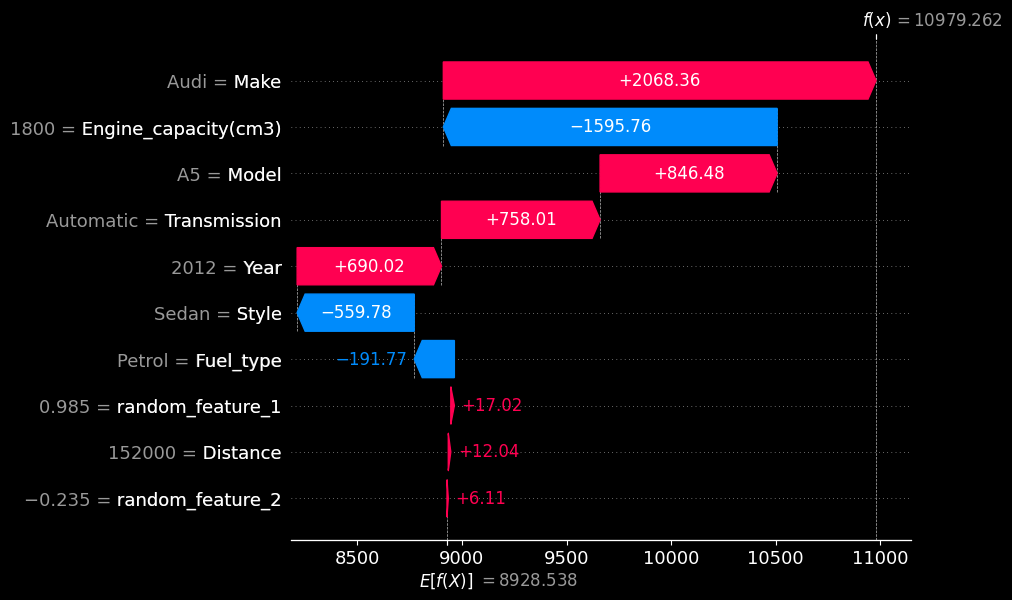

In [ ]:
#@title { run: "auto" }
index  = 2620 #@param {type:"slider", min:0, max:9746, step:10}

shap.plots.waterfall(shap_values_cb[index],
                     max_display=14)

Несколько индивидуальных предсказаний

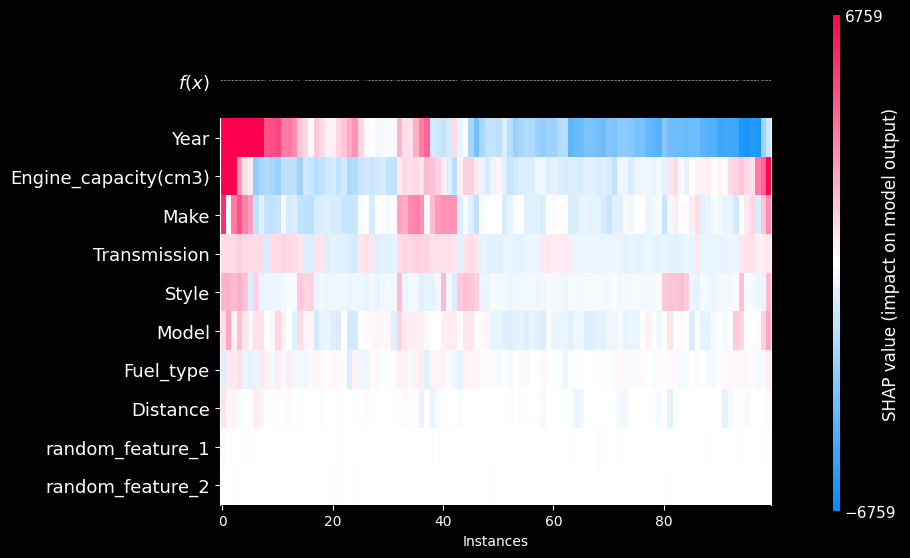

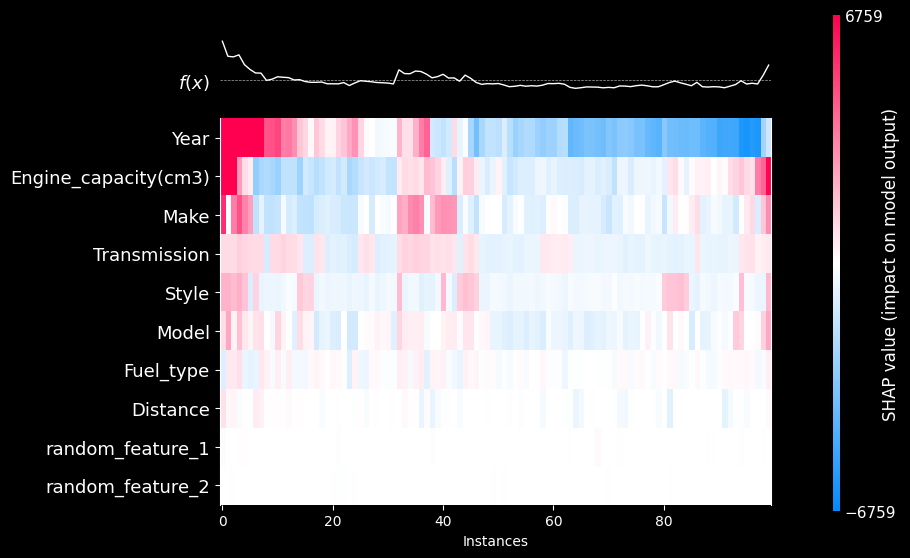

In [ ]:
#@title { run: "auto" }
index  = 2900 #@param {type:"slider", min:0, max:9646, step:10}


f1 = plt.figure()

shap.plots.heatmap(shap_values_cb[index:index+100])

# за темный фон, как за любые принципы нужно страдать
f1.gca().get_lines()[1].set_color('white')

f1

Индивидуальные (в плане признаков) графики

Скатерограмнки, но можно подкрафиать по другим признакам (проверка со-зависимости)

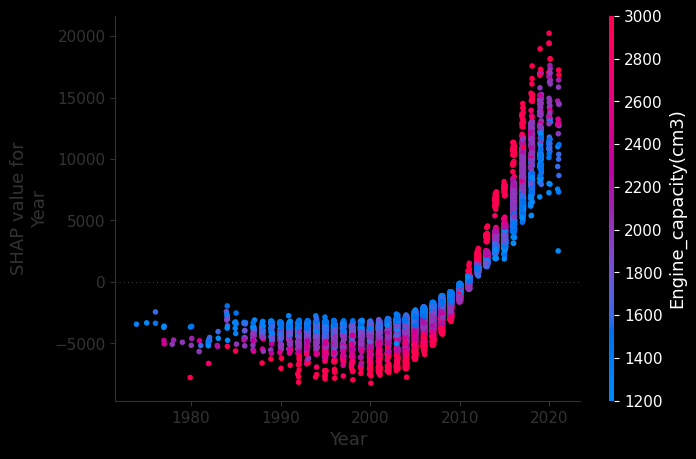

In [ ]:
#@title { run: "auto" }
index_plot  = "Year" #@param [ 'Year', 'Distance', 'Engine_capacity(cm3)','random_feature_1','random_feature_2'] {allow-input: true}
index_color  = "Engine_capacity(cm3)" #@param ['Year', 'Distance', 'Engine_capacity(cm3)','random_feature_1','random_feature_2'] {allow-input: true}


shap.plots.scatter(
                   shap_values_cb[:,index_plot],
                   color=shap_values_cb[:,index_color]
                  )